# Expectation-Maximization for Gaussian Mixture Models

This notebook demonstrates a from-scratch implementation of the Expectation-Maximization (EM) algorithm for Gaussian Mixture Models (GMMs). It compares two initialization strategies — KMeans and random — and includes both static and interactive visualizations. The implementation is organized as a modular Python package `emgmm`.


## 1. Generate synthetic data

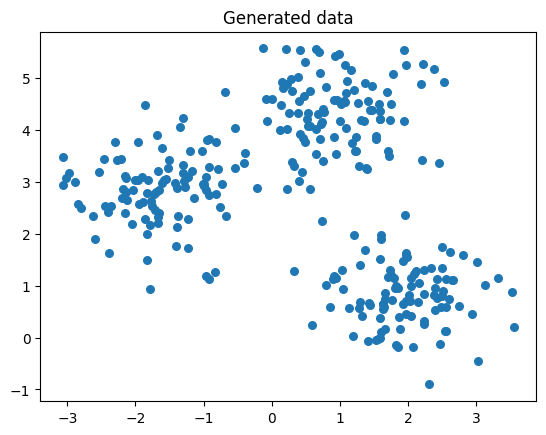

In [61]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt

# Generate 2D data with 3 clusters
X, y_true = make_blobs(n_samples=300, centers=3, cluster_std=0.65, random_state=0)

plt.scatter(X[:, 0], X[:, 1], s=30)
plt.title("Generated data")
plt.show()

## 2. Fit the GMM model using EM with KMeans/random initialization

In [62]:
from emgmm import GMM

gmm = GMM(n_components=3, init_method="kmeans", verbose=False)
gmm.fit(X)
labels_kmeans = gmm.predict(X)


In [63]:
# Fit the GMM model using EM with random initialization
gmm_random = GMM(n_components=3, init_method="random", verbose=False)
gmm_random.fit(X)
labels_random = gmm_random.predict(X)


## 3. Static visualization (interactive Plotly plot)

In [64]:
from emgmm import plot_gmm_interactive

plot_gmm_interactive(X, labels_kmeans, gmm.means_, gmm.covariances_)


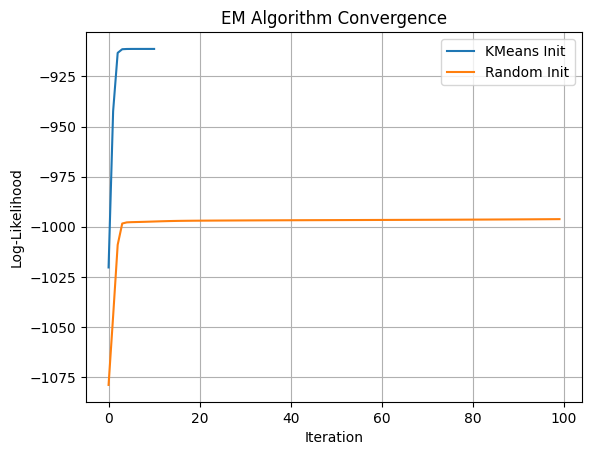

In [65]:
import matplotlib.pyplot as plt

plt.plot(gmm.log_likelihood_, label="KMeans Init")
plt.plot(gmm_random.log_likelihood_, label="Random Init")
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.title("EM Algorithm Convergence")
plt.legend()
plt.grid(True)
plt.show()


## 4. EM convergence animation

### K-means

In [66]:
from emgmm import animate_em_history
from IPython.display import HTML

anim = animate_em_history(X, gmm.history_, max_frames=10)
HTML(anim.to_jshtml())

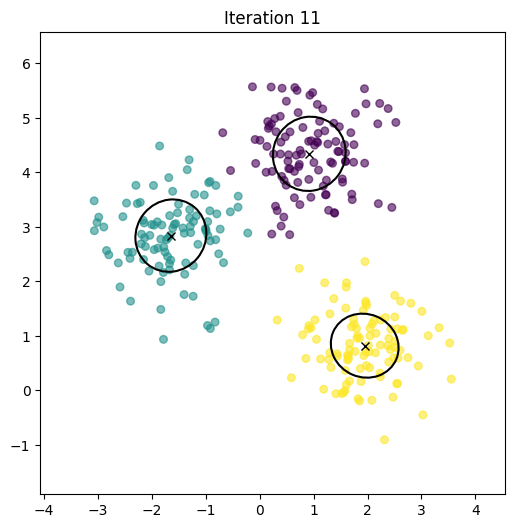

In [ ]:
animate_em_history(X, gmm.history_, save_path="../figures/animation_kmeans.gif")

### Random inicialization

In [68]:
anim = animate_em_history(X, gmm_random.history_, max_frames=10)
HTML(anim.to_jshtml())

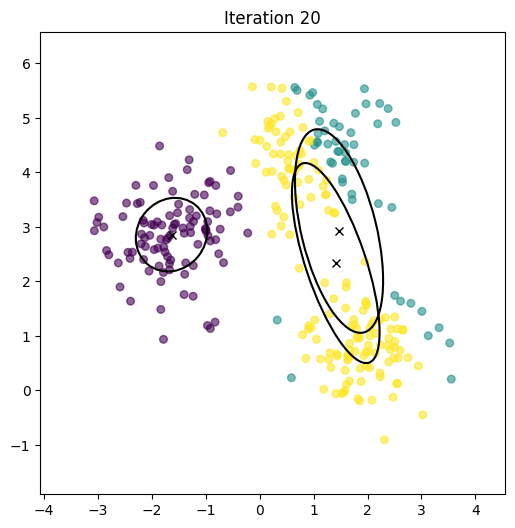

In [69]:
history_short = {
    "means": gmm_random.history_["means"][:20],
    "covariances": gmm_random.history_["covariances"][:20],
    "labels": gmm_random.history_["labels"][:20]
}

animate_em_history(X, history_short, save_path="../figures/animation_random.gif")

## 5. Comparison: KMeans vs Random initialization

Running experiments: 100%|██████████| 10/10 [00:00<00:00, 16.99it/s]


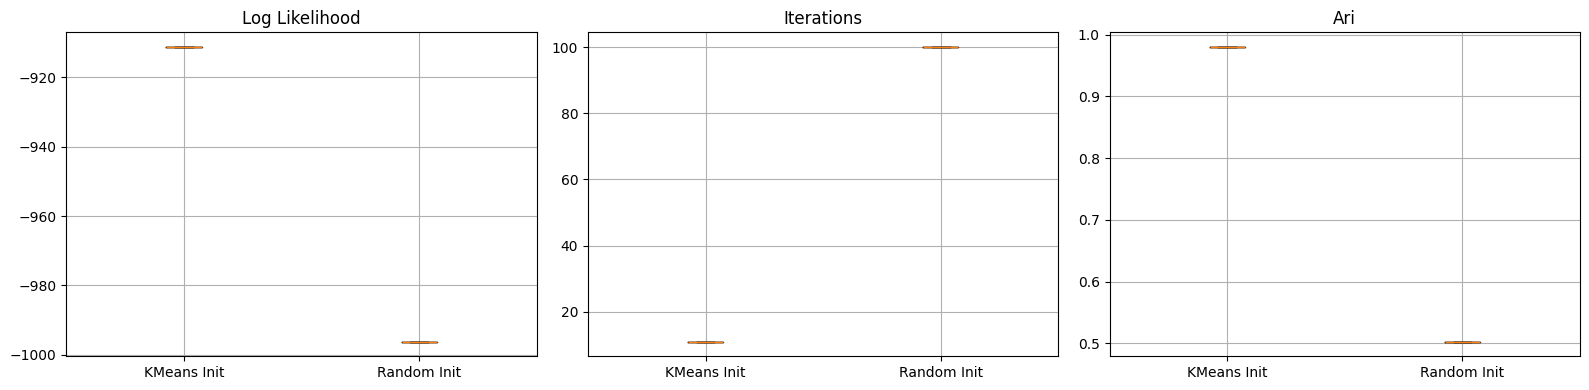

In [70]:
from emgmm import run_multiple_experiments, plot_results_comparison

results = run_multiple_experiments(X, y_true=y_true, n_runs=10, n_components=3)
plot_results_comparison(results)


The results show a clear difference between the two initialization strategies. Initializing the EM algorithm with KMeans leads to faster convergence, better log-likelihood scores, and more accurate cluster assignments compared to random initialization. These findings highlight the importance of proper initialization when fitting mixture models.


## 6. Augmenting cluster overlap

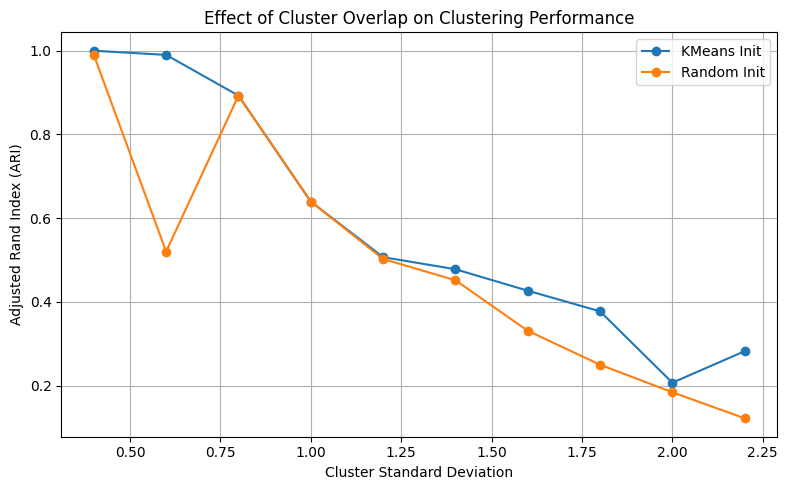

In [71]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score
from emgmm import GMM

# Define a range of standard deviations (increasing cluster overlap)
std_values = np.linspace(0.4, 2.2, 10)
ari_kmeans = []
ari_random = []

for std in std_values:
    X, y_true = make_blobs(n_samples=300, centers=3, cluster_std=std, random_state=0)

    gmm_k = GMM(n_components=3, init_method="kmeans")
    gmm_k.fit(X)
    labels_k = gmm_k.predict(X)
    ari_kmeans.append(adjusted_rand_score(y_true, labels_k))

    gmm_r = GMM(n_components=3, init_method="random")
    gmm_r.fit(X)
    labels_r = gmm_r.predict(X)
    ari_random.append(adjusted_rand_score(y_true, labels_r))

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(std_values, ari_kmeans, label="KMeans Init", marker='o')
plt.plot(std_values, ari_random, label="Random Init", marker='o')
plt.xlabel("Cluster Standard Deviation")
plt.ylabel("Adjusted Rand Index (ARI)")
plt.title("Effect of Cluster Overlap on Clustering Performance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Influence of Cluster Overlap on Initialization Strategy

The plot above illustrates how cluster overlap (controlled by the standard deviation of each Gaussian) affects the performance of the EM algorithm under different initialization strategies.

- When clusters are well separated (low standard deviation), KMeans initialization consistently yields high clustering accuracy (measured by ARI), while Random initialization is more variable.
- As the clusters begin to overlap, the ARI scores decrease for both strategies, and the advantage of KMeans diminishes.
- With high overlap (e.g. std > 1.5), both strategies converge to similarly suboptimal solutions due to the inherent ambiguity in the data structure.

This confirms that initialization has a strong impact when the data structure is clear, but less so when clusters are inherently indistinct.

